In [4]:
import pandas as pd
import numpy as np

# For preprocessing and model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# For class imbalance
from imblearn.over_sampling import SMOTE

# For modeling
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# For tuning
from sklearn.model_selection import GridSearchCV

# For evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
# Separate features and target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# First, split into train + temp (90%) and test (10%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_scaled, y, test_size=0.10, random_state=42, stratify=y
)

# Now split train_val into train (70%) and validation (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=2/9, random_state=42, stratify=y_train_val
)

# Print shape confirmation
print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")
print(f"Test shape: {X_test.shape}")


Train shape: (537, 8)
Validation shape: (154, 8)
Test shape: (77, 8)


In [7]:
from collections import Counter
from imblearn.over_sampling import SMOTE

# Check original class distribution
print("Before SMOTE:", Counter(y_train))

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check new class distribution
print("After SMOTE:", Counter(y_train_resampled))


Before SMOTE: Counter({0: 350, 1: 187})
After SMOTE: Counter({0: 350, 1: 350})


In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define the model
svm = SVC()

# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Perform GridSearch with 5-fold CV
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Best parameters and model
print("Best Params:", grid_search.best_params_)
best_model = grid_search.best_estimator_


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


Validation Metrics:
              precision    recall  f1-score   support

           0       0.81      0.73      0.77       100
           1       0.58      0.69      0.63        54

    accuracy                           0.71       154
   macro avg       0.69      0.71      0.70       154
weighted avg       0.73      0.71      0.72       154

Test Metrics:
              precision    recall  f1-score   support

           0       0.87      0.80      0.83        50
           1       0.68      0.78      0.72        27

    accuracy                           0.79        77
   macro avg       0.77      0.79      0.78        77
weighted avg       0.80      0.79      0.80        77



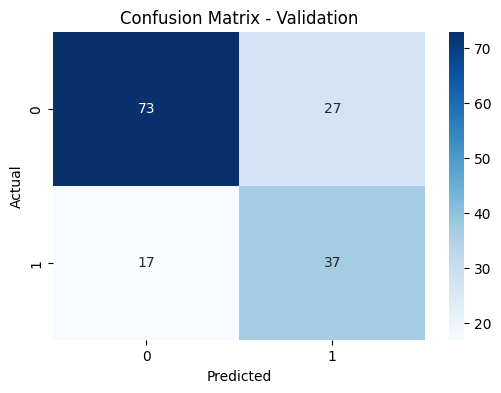

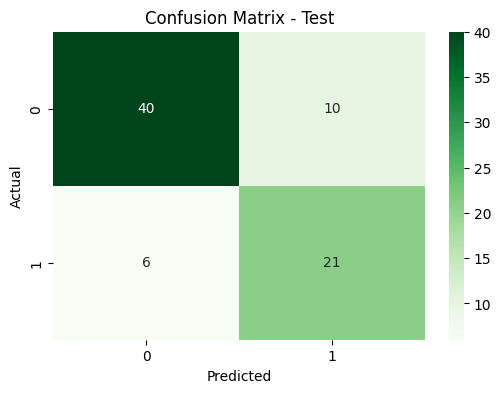

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on validation and test sets
val_preds = best_model.predict(X_val)
test_preds = best_model.predict(X_test)

# Accuracy measures
print("Validation Metrics:")
print(classification_report(y_val, val_preds))

print("Test Metrics:")
print(classification_report(y_test, test_preds))

# Confusion Matrix - Validation
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_val, val_preds), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Validation")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Confusion Matrix - Test
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, test_preds), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Test")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
